# Preliminary Data Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import dowhy

## Players preprocess

In [2]:
players_df = pd.read_csv(r'players.csv')
for col in players_df.columns:
    if 'career' in col:
        players_df.drop(col, axis=1, inplace=True)
players_df = players_df[players_df['draft_pick'].notna()] # remove players with no draft pick
players_df = players_df[players_df["draft_pick"].str.contains('overall')] # remove players with no valid draft pick
# drop the 'height' column
players_df = players_df.drop(columns=['height'])
# remove all players 
players_df = players_df[players_df['draft_round'].notna()] # remove players with no draft pick
players_df = players_df[players_df["draft_round"].str.contains('1') | players_df["draft_round"].str.contains('2')] # remove players with no valid draft pick

# Remove all non-numeric digits frpm the draft pick column and convert to int
players_df['draft_pick'] = players_df['draft_pick'].str.replace(r'\D', '',  regex=True).astype(int) # remove all non-numeric digits from the draft pick column and convert to int
players_df['draft_round'] = players_df['draft_round'].str.replace(r'\D', '', regex=True).astype(int) # remove all non-numeric digits from the draft round column and convert to int
players_df['weight'] = players_df['weight'].str.replace(r'\D', '', regex=True).astype(int) # remove all non-numeric digits from the weight column and convert to int
players_df['position'] = players_df['position'].apply(lambda x: tuple(re.split(' and |, |/',x))[0]) # remove all positions after the first

players_df['birthDate'] = pd.to_datetime(players_df['birthDate']) # convert birthDate to datetime
players_df['birthYear'] = players_df["birthDate"].dt.year.notnull().astype(int) # create birthYear column
players_df.drop(['birthDate'], axis = 1, inplace = True) 

players_df['draft_year'] = players_df['draft_year'].astype(int) # convert draft_year to int
players_df = players_df.drop(players_df[players_df['draft_pick'] > 60].index) # remove players with draft pick > 60


In [3]:
# add height from the Players_height.csv file based on the player's name
players_height_df = pd.read_csv(r'Players_height.csv') 
players_height_df = players_height_df[['Player', 'height']]
players_height_df = players_height_df.rename(columns={'Player': 'name'})
players_df = pd.merge(players_df, players_height_df, on='name', how='left')


In [4]:
percent_missing = players_df.isnull().sum() * 100 / len(players_df)
missing_value_players_df = pd.DataFrame({'column_name': players_df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_players_df

,column_name,percent_missing
0,_id,0.000000
1,birthPlace,2.796919
2,college,8.877179
3,draft_pick,0.000000
4,draft_round,0.000000
5,draft_team,0.000000
6,draft_year,0.000000
7,highSchool,8.350223
8,name,0.000000
9,position,0.000000


In [5]:
players_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,shoots,weight,birthYear,height
0,smartke01,"Baton Rouge, Louisiana",Indiana University,41,2,Golden State Warriors,1988,"McKinley in Baton Rouge, Louisiana",Keith Smart,Point Guard,Right,175,1,185.0
1,belltr01,"Minneapolis, Minnesota",Boston College,16,1,Boston Celtics,2003,"Academy of Holy Angels in Richfield, Minnesota",Troy Bell,Point Guard,Right,180,1,185.0
2,kileyja01,NaN,Syracuse University,13,2,Fort Wayne Pistons,1951,NaN,Jack Kiley,Shooting Guard,Right,170,1,185.0
3,tonkoan01,"Barrackville, West Virginia",Marshall University,1,1,Providence Steamrollers,1948,"Union in Benwood, West Virginia",Andy Tonkovich,Guard,Right,185,1,NaN
4,paigema01,"Cedar Rapids, Iowa",University of North Carolina,55,2,Brooklyn Nets,2016,"Linn-Marr in Marion, Iowa",Marcus Paige,Point Guard,Left,175,1,NaN


In [6]:
print(len(players_df))

2467


## Salaries preprocess

In [7]:
salary_df = pd.read_csv(r'salaries_1985to2018.csv')

# drop the 'season_start', 'team' and 'season' columns
salary_df = salary_df.drop(columns=['season_start', 'team', 'season', 'league'])
salary_df = salary_df.rename(columns={'season_end': 'Year', 'player_id': '_id'})
print(salary_df.dtypes)
print(len(salary_df))

_id       object
salary     int64
Year       int64
dtype: object
14163


In [8]:
percent_missing = salary_df.isnull().sum() * 100 / len(salary_df)
missing_value_salary_df = pd.DataFrame({'column_name': salary_df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_salary_df

,column_name,percent_missing
0,_id,0.0
1,salary,0.0
2,Year,0.0


In [9]:
salary_df.head(5)

,_id,salary,Year
0,abdelal01,395000,1991
1,abdelal01,494000,1992
2,abdelal01,500000,1993
3,abdelal01,805000,1994
4,abdelal01,650000,1995


## Merge the 2 datasets and add 'season stats' dataset

The 'season stats' dataset contains data about the players' performance in each season throughout multiple seasons.

In [10]:
ps_df = pd.merge(players_df, salary_df, on='_id', how='right')
ps_df['draft_pick'] = ps_df['draft_pick'].astype('Int64')
ps_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,shoots,weight,birthYear,height,salary,Year
0,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,395000,1991
1,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,494000,1992
2,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,500000,1993
3,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,805000,1994
4,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,650000,1995


In [11]:
p_stats_df = pd.read_csv(r'data\Seasons_Stats.csv')
print(len(p_stats_df))
p_stats_df = p_stats_df.rename(columns={'Player': 'name'})
p_stats_df = p_stats_df[['name',
                         'Year',
                         'Tm',
                         'PER',
                         'PTS',
                         'TS%',
                         'MP',
                         'OWS',
                         'DWS',
                         'WS/48',
                         'FG%',
                         'AST'
                         ]]
ps_df = pd.merge(ps_df, p_stats_df, on=['name', 'Year'], how='left')

24691


In [12]:
ps_df = ps_df[ps_df['salary'].notna()]
ps_df = ps_df[ps_df['draft_pick'].notna()]
ps_df = ps_df[ps_df['PER'].notna()]
ps_df = ps_df.drop(ps_df[ps_df['Year'] - ps_df['draft_year'] > 5].index) # Keep only first 5 seasons after draft for each player
ps_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,...,Tm,PER,PTS,TS%,MP,OWS,DWS,WS/48,FG%,AST
0,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,POR,13.1,135.0,0.499,290.0,0.0,0.5,0.079,0.474,12.0
1,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,POR,13.5,432.0,0.533,934.0,0.6,1.5,0.110,0.493,30.0
2,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,TOT,13.2,578.0,0.551,1311.0,0.7,1.3,0.074,0.518,27.0
3,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,MIL,11.9,64.0,0.508,159.0,0.0,0.2,0.035,0.464,10.0
4,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,BOS,13.4,514.0,0.557,1152.0,0.7,1.2,0.079,0.525,17.0


# Analysis of average salary over first 5 years of the career

In [13]:
# devide the salaries by the mean salary of each year
mean_salary_df = ps_df[['Year', 'salary']].groupby(['Year']).median().reset_index()
mean_salary_df = mean_salary_df.rename(columns={'salary': 'mean_salary'})
ps_df_year_norm = pd.merge(ps_df, mean_salary_df, on='Year', how='left')
ps_df_year_norm['salary'] = ps_df_year_norm['salary'] / ps_df_year_norm['mean_salary']
ps_df_year_norm = ps_df_year_norm.drop(columns=['mean_salary'])


teams_df = ps_df[['Tm', '_id']].groupby('_id').first().reset_index()
avg_salary = ps_df[['PER', '_id', 'salary', 'draft_pick', 'draft_year']].groupby(['_id']).mean().reset_index()
avg_salary = pd.merge(avg_salary, teams_df, on='_id', how='left')
avg_salary['draft_pick'] = avg_salary['draft_pick'].astype('Int64')
avg_salary['draft_year'] = avg_salary['draft_year'].astype('Int64')

avg_salary_year_norm = ps_df_year_norm[['PER', '_id', 'salary', 'draft_pick', 'draft_year']].groupby(['_id']).mean().reset_index()
avg_salary_year_norm = pd.merge(avg_salary_year_norm, teams_df, on='_id', how='left')
avg_salary_year_norm['draft_pick'] = avg_salary_year_norm['draft_pick'].astype('Int64')
avg_salary_year_norm['draft_year'] = avg_salary_year_norm['draft_year'].astype('Int64')
avg_salary_year_norm

,_id,PER,salary,draft_pick,draft_year,Tm
0,abdelal01,9.833333,0.745210,25,1990,POR
1,abdulma02,14.980000,2.823922,3,1990,DEN
2,abdulta01,9.655556,2.390801,11,1997,SAC
3,abdursh01,18.900000,5.835999,3,1996,VAN
4,abrinal01,10.100000,3.120128,32,2013,OKC
...,...,...,...,...,...,...
1538,zhizhwa01,16.037500,1.007511,36,1999,DAL
1539,zidekge01,9.971429,0.633519,22,1995,CHH
1540,zimmest01,7.300000,0.494452,41,2016,ORL
1541,zipsepa01,6.900000,0.390357,48,2016,CHI


# Create causal model

## Add treatment variable and filter the dataset accordingly

### Choosing upper and lower bounds

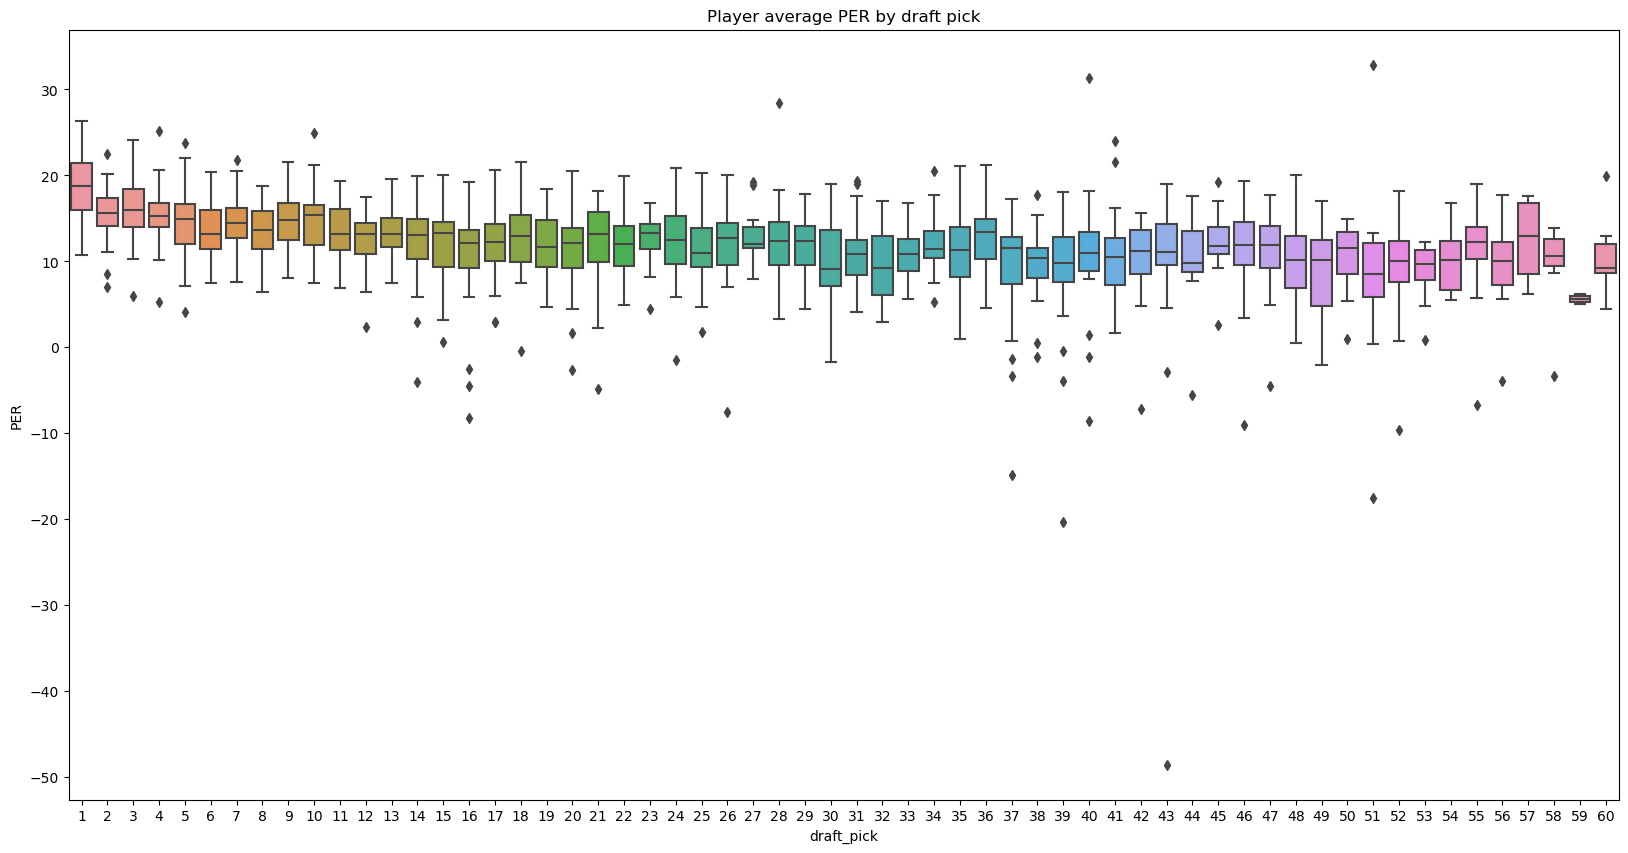

In [116]:
dp_per_df = ps_df[['draft_pick', 'PER', 'name']].groupby('name').mean().reset_index()
dp_per_df['draft_pick'] = dp_per_df['draft_pick'].astype('Int64')
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Player average PER by draft pick')
sns.boxplot(x="draft_pick", y="PER", data=dp_per_df)
plt.show()

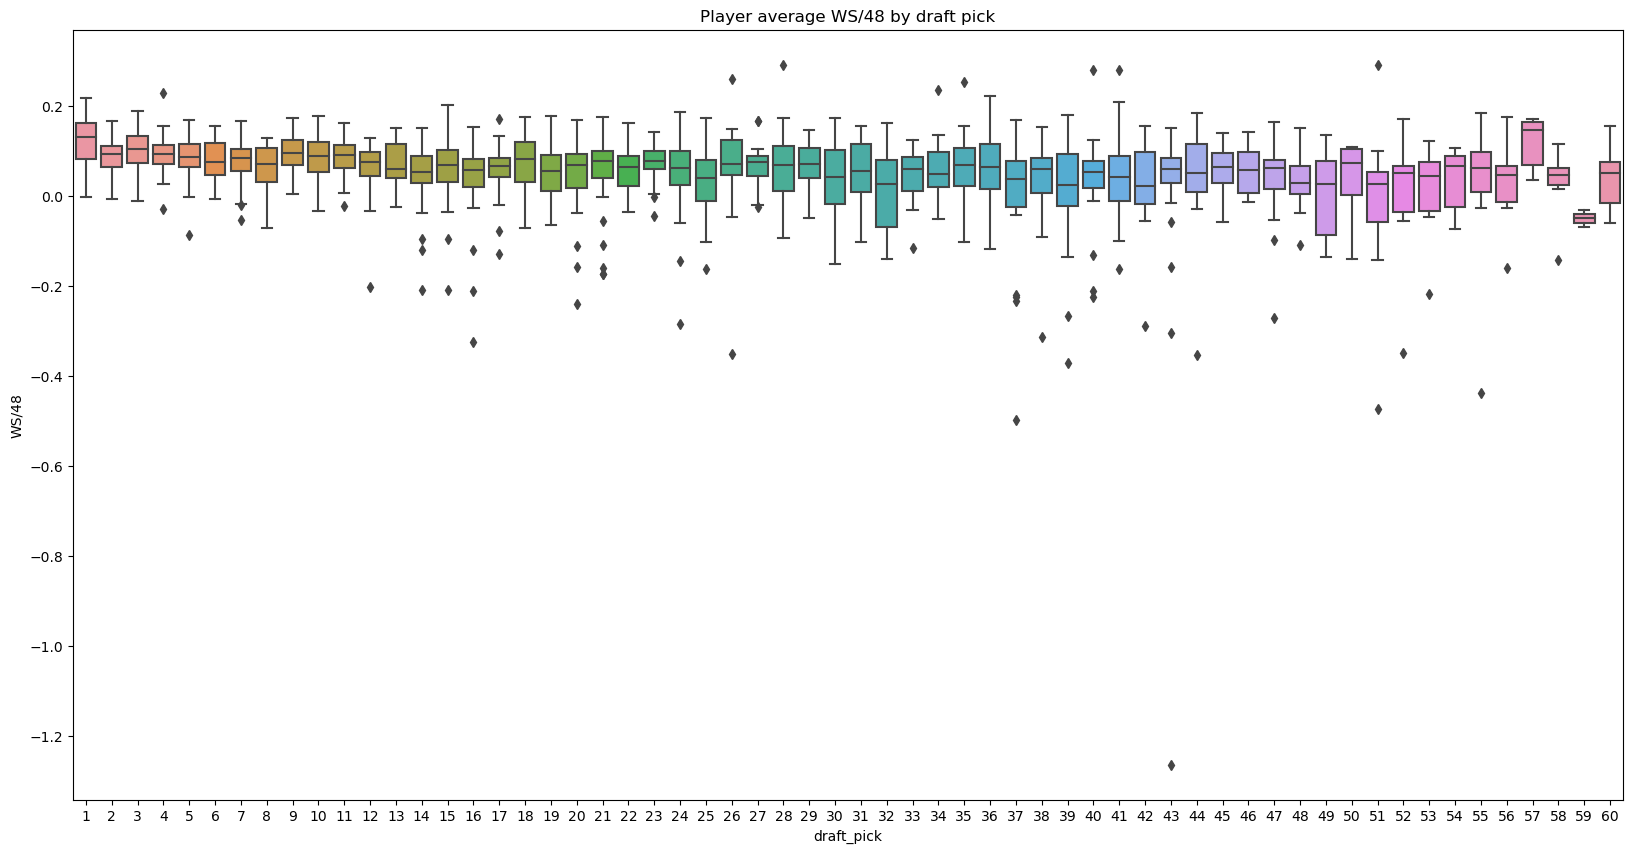

In [117]:
dp_ws48_df = ps_df[['draft_pick', 'WS/48', 'name']].groupby('name').mean().reset_index()
dp_ws48_df['draft_pick'] = dp_per_df['draft_pick'].astype('Int64')
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Player average WS/48 by draft pick')
sns.boxplot(x="draft_pick", y="WS/48", data=dp_ws48_df)
plt.show()

### Not normalized by year mean salary

In [77]:
pd.options.mode.chained_assignment = None  # default='warn'

upper_bound = 5
lower_bound = 15 # This is lower because it refers to decreasing placement
ps_treat_df = ps_df[(ps_df['draft_pick'] <= lower_bound) & (ps_df['draft_pick'] >= upper_bound)] # Keep only relevant players who were selected between places 28-33

# 1- better placement, 0- worse placement
# ps_treat_df['T'] = ps_treat_df['draft_pick'].apply(lambda x: 1 if x <= upper_bound + (lower_bound - upper_bound)/2 else 0).to_numpy()
ps_treat_df.loc[ps_treat_df['draft_pick'] <= upper_bound + (lower_bound - upper_bound)/2, 'T'] = 1
ps_treat_df.loc[ps_treat_df['draft_pick'] > upper_bound + (lower_bound - upper_bound)/2, 'T'] = 0
ps_treat_df['T'] = ps_treat_df['T'].astype('Int64')
avg_treat_salary = ps_treat_df[['PER', '_id', 'salary', 'draft_year', 'T', 'WS/48', 'OWS', 'PTS', 'DWS', 'AST', 'MP', 'TS%', 'FG%', 'draft_pick']].groupby(['_id']).mean().reset_index()

In [78]:
avg_treat_salary['T'].value_counts().to_frame()

,T
1.0,212
0.0,173


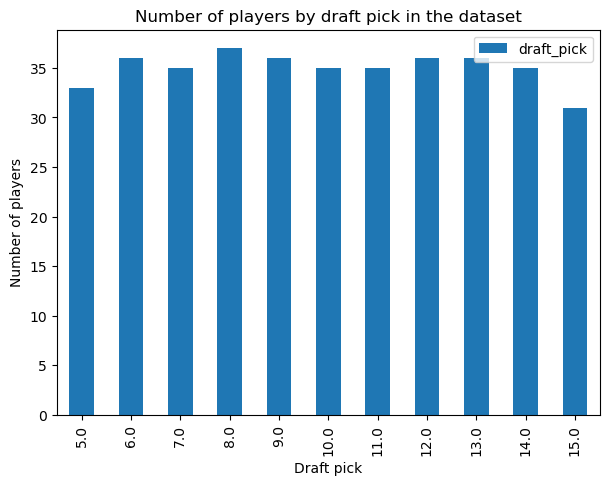

In [79]:
ps_treat_rank_count = avg_treat_salary['draft_pick'].value_counts().to_frame().sort_index().plot.bar(figsize=(7,5))
avg_treat_salary = avg_treat_salary.drop(columns=['draft_pick'])
plt.title('Number of players by draft pick in the dataset')
plt.xlabel('Draft pick')
plt.ylabel('Number of players')
plt.show()
# sns.histplot(data=ps_treat_rank_count, x='index', y='draft_pick')

In [80]:
print(avg_treat_salary.columns)

Index(['_id', 'PER', 'salary', 'draft_year', 'T', 'WS/48', 'OWS', 'PTS', 'DWS',
       'AST', 'MP', 'TS%', 'FG%'],
      dtype='object')


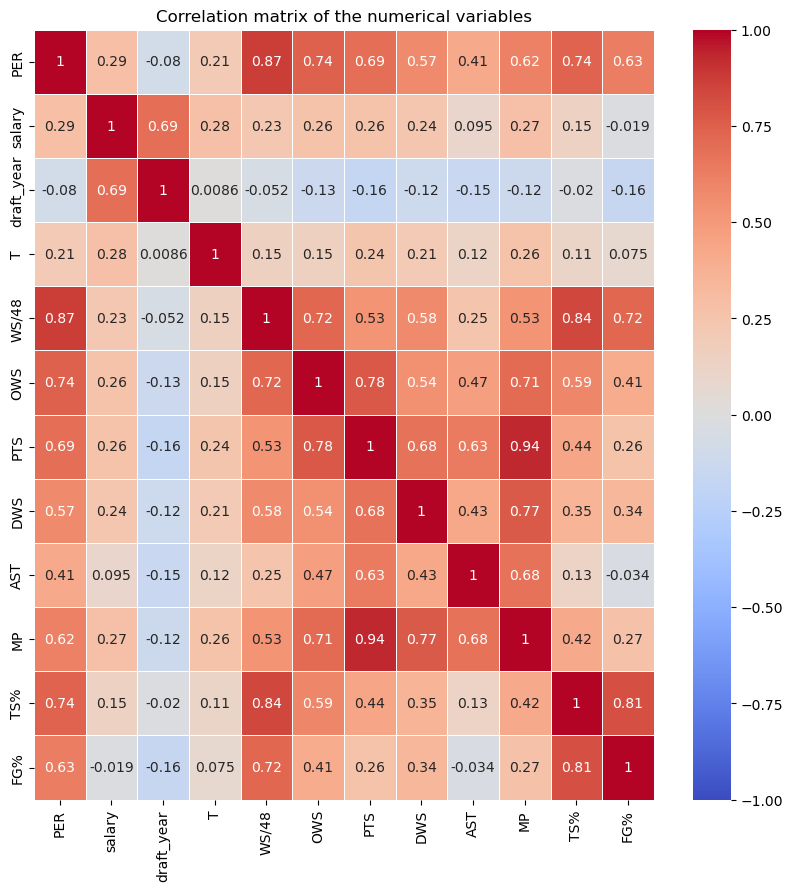

In [81]:
correlation_df = avg_treat_salary[['PER', 'salary', 'draft_year', 'T', 'WS/48', 'OWS', 'PTS', 'DWS', 'AST', 'MP', 'TS%', 'FG%']]
corr_mat = correlation_df.corr()
# corr_mat = corr_mat.round(2)[corr_mat > 0.5]
ax, fig = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat, annot =True, cmap="coolwarm", vmin=-1, vmax=1, linewidth=.5)
plt.title('Correlation matrix of the numerical variables')
plt.show()

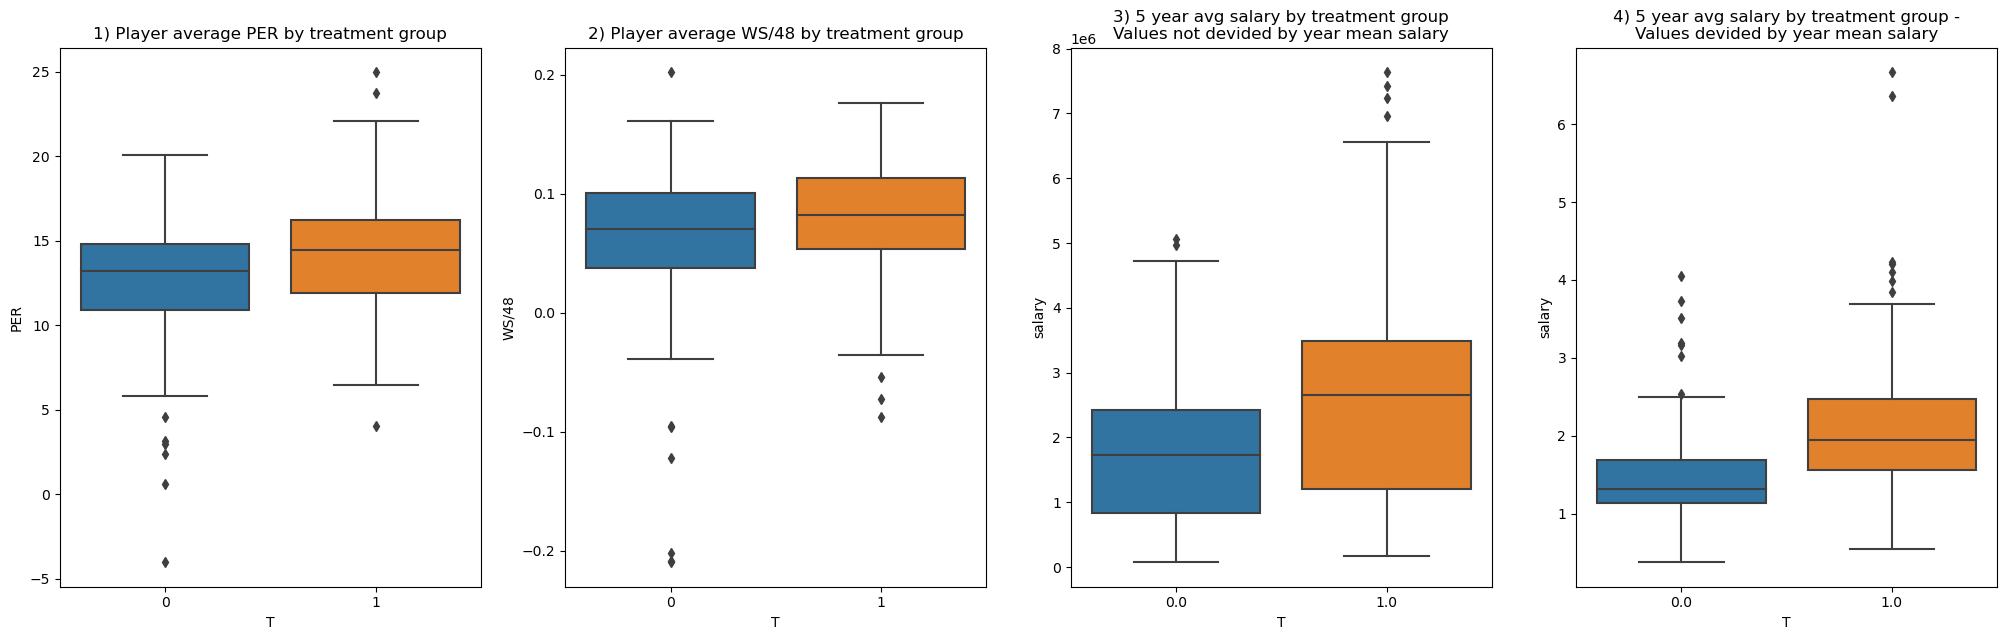

In [82]:
dp_per_df = ps_treat_df[['PER', 'name', 'T']].groupby('name').mean().reset_index()
dp_per_df['T'] = dp_per_df['T'].astype('Int64')
fig, ax = plt.subplots(1,4, figsize=(25, 7))
ax[0].set_title('1) Player average PER by treatment group')
sns.boxplot(x="T", y="PER", data=dp_per_df, ax=ax[0])

dp_ws48_df = ps_treat_df[['WS/48', 'name', 'T']].groupby('name').mean().reset_index()
dp_ws48_df['T'] = dp_ws48_df['T'].astype('Int64')
ax[1].set_title('2) Player average WS/48 by treatment group')
sns.boxplot(x="T", y="WS/48", data=dp_ws48_df, ax=ax[1])

# Not normalized by year mean salary
sns.boxplot(data=avg_treat_salary, x='T', y='salary', ax=ax[2])
ax[2].set_title('3) 5 year avg salary by treatment group\nValues not devided by year mean salary')

# 
ps_treat_df_year_norm = ps_df_year_norm[(ps_df_year_norm['draft_pick'] <= lower_bound) & (ps_df_year_norm['draft_pick'] >= upper_bound)] # Keep only relevant players who were selected between places 28-33

# 1- better placement, 0- worse placement
ps_treat_df_year_norm['T'] = ps_treat_df_year_norm['draft_pick'].apply(lambda x: 1 if x <= upper_bound + (lower_bound - upper_bound)/2 else 0).to_numpy()

avg_treat_salary_year_norm = ps_treat_df_year_norm[['PER', '_id', 'salary', 'draft_pick', 'draft_year', 'T']].groupby(['_id']).mean().reset_index()
sns.boxplot(data=avg_treat_salary_year_norm, x='T', y='salary', ax=ax[3])
ax[3].set_title('4) 5 year avg salary by treatment group -\nValues devided by year mean salary')
plt.show()

### Normalized by year mean salary

In [83]:
ps_treat_df_year_norm = ps_df_year_norm[(ps_df_year_norm['draft_pick'] <= lower_bound) & (ps_df_year_norm['draft_pick'] >= upper_bound)] # Keep only relevant players who were selected between places 28-33

# 1- better placement, 0- worse placement
ps_treat_df_year_norm['T'] = ps_treat_df_year_norm['draft_pick'].apply(lambda x: 1 if x <= upper_bound + (lower_bound - upper_bound)/2 else 0).to_numpy()

avg_treat_salary_year_norm = ps_treat_df_year_norm[['PER', '_id', 'salary', 'draft_pick', 'draft_year', 'T']].groupby(['_id']).mean().reset_index()

### Assumption: All variables that have something to do with the player's talent, even though they are messured after the draft we will treat them as if they represent the objective talent of the player that has not changed over the years.

Now we will check how plausible this assumption is. we will check how the personal performance covariates change throughout the years using the player_stats dataset.

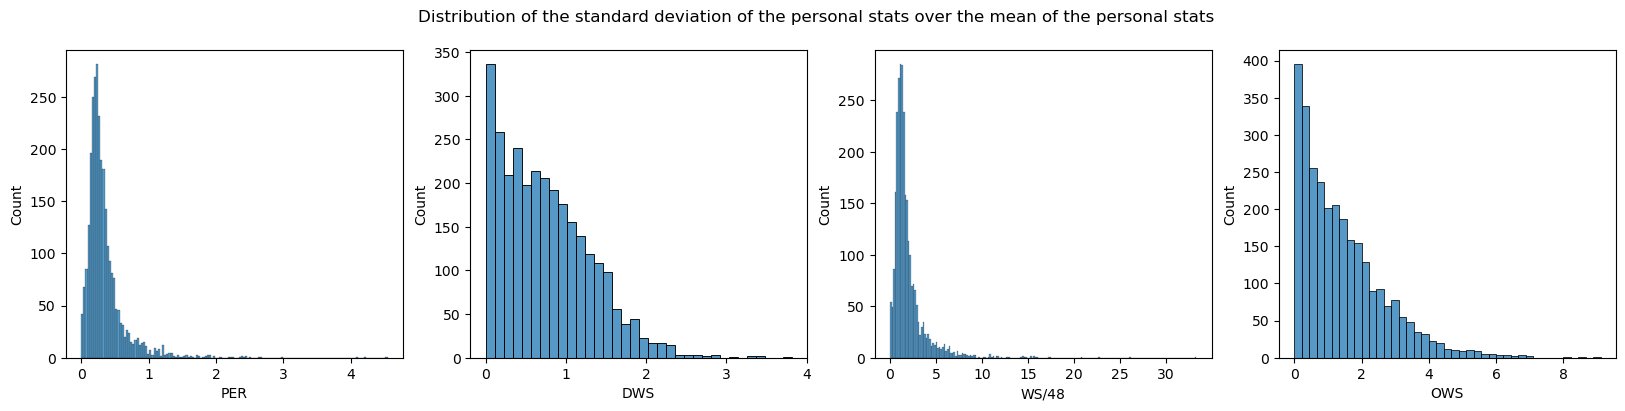

In [115]:
p_agg_stats = p_stats_df[['name',
                          'PER',
                          'DWS',
                          'WS/48',
                          'OWS'
                          ]]
def compute_std_over_mean(x): # Coefficient of variation, which is a dimensionless measure of dispersion of a probability distribution around the mean
    if x.notnull().sum().sum() <= 1:
        return np.nan
    return np.std(list(x))/np.nanmean(list(x)) if np.nanmean(x.tolist()) != 0 else np.nan
    
# personal_stats_df = p_agg_stats.groupby('name').agg(compute_std_over_mean)
personal_stats_df = p_agg_stats.groupby('name').std()
col_means_dict = {col: p_agg_stats.groupby('name').mean()[col].mean() for col in p_agg_stats.columns[1:]}
for col in personal_stats_df.columns:
    personal_stats_df[col] = personal_stats_df[col]/col_means_dict[col]

personal_stats_df = personal_stats_df.dropna()
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx, col_name in enumerate(personal_stats_df.columns):
    ax = sns.histplot(x=col_name, ax=axes[idx], data=personal_stats_df)
plt.suptitle('Distribution of the standard deviation of the personal stats over the mean of the personal stats')
plt.show()

## Create causal graph and causal model

In [58]:
from pandas.api.types import is_numeric_dtype
from scipy import stats

def mean_str(col):
    if is_numeric_dtype(col):
        return col.mean()
    else:
        return col.mode()

avg_treat_salary = ps_treat_df.copy()
avg_treat_salary.sort_values(by='Year', ascending=True, inplace=True)
avg_treat_salary = avg_treat_salary.groupby('_id').agg(mean_str)
avg_treat_salary = avg_treat_salary.drop(columns=['Year', 'name', 'draft_round', 'draft_pick', 'Tm', 'shoots', 'weight']) # Delete irrelevant columns
avg_treat_salary['college'] = avg_treat_salary['college'].apply(lambda x: None if type(x)!=str else x)
avg_treat_salary['highSchool'] = avg_treat_salary['highSchool'].apply(lambda x: None if type(x)!=str else x)
avg_treat_salary = avg_treat_salary.drop(columns=['birthPlace', 'college', 'highSchool'])

percent_missing = avg_treat_salary.isnull().sum() * 100 / len(avg_treat_salary)
missing_value_avg_treat_salary = pd.DataFrame({'column_name': avg_treat_salary.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_avg_treat_salary
# # Remove outliers
# for col in avg_treat_salary.columns:
#     if is_numeric_dtype(avg_treat_salary[col]):
#         avg_treat_salary = avg_treat_salary[(np.abs(stats.zscore(avg_treat_salary[col])) < 8)]

,column_name,percent_missing
0,draft_team,0.0
1,draft_year,0.0
2,position,0.0
3,birthYear,0.0
4,height,0.0
5,salary,0.0
6,PER,0.0
7,PTS,0.0
8,TS%,0.0
9,MP,0.0


No cycles found


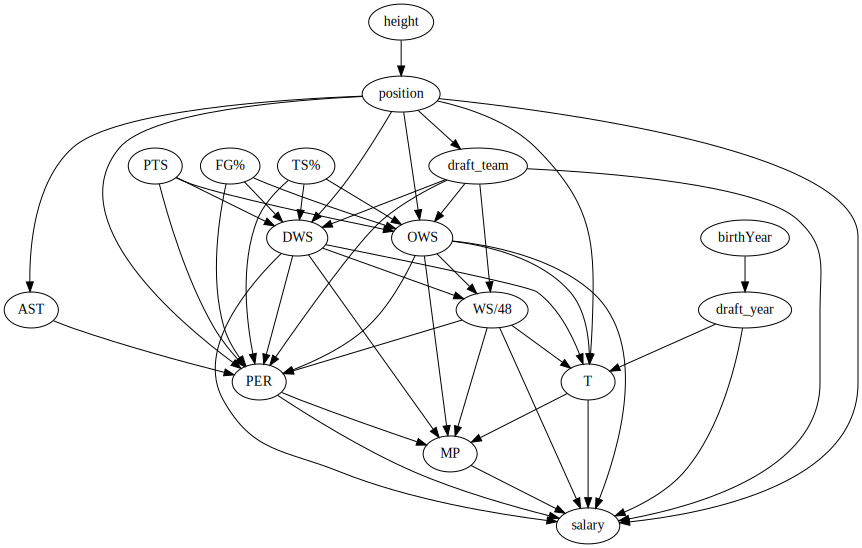

In [59]:
import graphviz
import networkx as nx
dot = graphviz.Digraph(comment='Causal Graph')
causal_graph = nx.DiGraph()
for att in avg_treat_salary.columns:
    dot.node(att, att)
    causal_graph.add_node(att)
        
edges = [
        # ('birthPlace', 'college'), ('birthPlace', 'highSchool'),
         ('birthYear', 'draft_year'),
         ('draft_team', 'salary'), ('draft_team', 'OWS'), ('draft_team', 'DWS'), ('draft_team', 'WS/48'), ('draft_team', 'PER'),
         ('draft_year', 'salary'), ('draft_year', 'T'),
        #  ('highSchool', 'T'), ('highSchool', 'college'), ('highSchool', 'draft_team'), 
         ('position', 'draft_team'), ('position', 'PER'), ('position', 'salary'), ('position', 'AST'), ('position', 'OWS'), ('position', 'DWS'), ('position', 'T'),
         ('height', 'position'),
         ('PER', 'salary'), ('PER', 'MP'),
         ('PTS', 'OWS'), ('PTS', 'DWS'), ('PTS', 'PER'),
         ('TS%', 'OWS'), ('TS%', 'DWS'), ('TS%', 'PER'),
         ('MP', 'salary'),
         ('OWS', 'salary'), ('OWS', 'PER'), ('OWS', 'MP'), ('OWS', 'WS/48'), ('OWS', 'T'),
         ('DWS', 'salary'), ('DWS', 'PER'), ('DWS', 'MP'), ('DWS', 'WS/48'), ('DWS', 'T'),
         ('WS/48', 'salary'), ('WS/48', 'PER'), ('WS/48', 'MP'), ('WS/48', 'T'),
         ('FG%', 'OWS'), ('FG%', 'DWS'), ('FG%', 'PER'),
         ('AST', 'PER'),
         ('T', 'salary'), ('T', 'MP')
         ]
# Create edges
for edge in edges:
    dot.edge(edge[0], edge[1])
    causal_graph.add_edge(edge[0], edge[1])

try:
    nx.find_cycle(causal_graph, orientation="original")
except:
    print("No cycles found")
dot

## Replace categorical variables with dummy variables & recreate dot

In [60]:
columns_need_dummy = ['draft_team', 'position']
for col in columns_need_dummy:
    print(col, avg_treat_salary[col].unique().shape[0])
columns_need_dummy_cats = {name: list(avg_treat_salary[name].unique()) for name in columns_need_dummy}
avg_treat_salary = pd.get_dummies(avg_treat_salary, columns=columns_need_dummy)
avg_treat_salary = avg_treat_salary.dropna()

for edge in edges:
    delete_edge = False
    if edge[0] in columns_need_dummy:
        delete_edge = True
        for cat in columns_need_dummy_cats[edge[0]]:
            edges.append((edge[0] + '_' + cat, edge[1]))
        
    if edge[1] in columns_need_dummy:
        delete_edge = True
        for cat in columns_need_dummy_cats[edge[1]]:
            edges.append((edge[0], edge[1] + '_' + cat))
    if delete_edge:
        edges.remove(edge)
    
dot = graphviz.Digraph(comment='Causal Graph')

for att in avg_treat_salary.columns:
    dot.node(att, att)
# Create edges
for edge in edges:
    dot.edge(edge[0], edge[1])
print('Num edges: ', len(edges))

draft_team 38
position 5
Num edges:  397


In [61]:
string_graph = str(dot).replace('\n', ';\n').replace('};', '}').replace('{;', '{').replace('h;', 'h').rstrip()
string_graph = string_graph[string_graph.find('// Causal Graph\n')+len('// Causal Graph\n'):]

In [62]:
avg_treat_salary.columns

Index(['draft_year', 'birthYear', 'height', 'salary', 'PER', 'PTS', 'TS%',
       'MP', 'OWS', 'DWS', 'WS/48', 'FG%', 'AST', 'T',
       'draft_team_Atlanta Hawks', 'draft_team_Boston Celtics',
       'draft_team_Charlotte Bobcats', 'draft_team_Charlotte Hornets',
       'draft_team_Chicago Bulls', 'draft_team_Cleveland Cavaliers',
       'draft_team_Dallas Mavericks', 'draft_team_Denver Nuggets',
       'draft_team_Detroit Pistons', 'draft_team_Golden State Warriors',
       'draft_team_Houston Rockets', 'draft_team_Indiana Pacers',
       'draft_team_Kansas City Kings', 'draft_team_Los Angeles Clippers',
       'draft_team_Los Angeles Lakers', 'draft_team_Memphis Grizzlies',
       'draft_team_Miami Heat', 'draft_team_Milwaukee Bucks',
       'draft_team_Minnesota Timberwolves', 'draft_team_New Jersey Nets',
       'draft_team_New Orleans Hornets', 'draft_team_New Orleans Pelicans',
       'draft_team_New Orleans/Oklahoma City Hornets',
       'draft_team_New York Knicks', 'draft_tea

In [63]:
avg_treat_salary['T'] = avg_treat_salary['T'].astype(bool) # Make sure treatment is binary

## Propensity score estimation

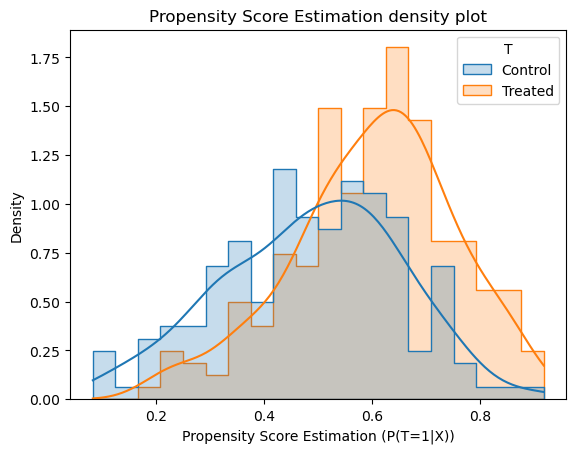

In [64]:
# Estimate the propensity score using a logistic regression model
from sklearn.linear_model import LogisticRegression

X = avg_treat_salary.drop(columns=['salary', 'T'])
y = avg_treat_salary['T']
s1 = pd.Series(y, name='T').reset_index(drop=True)
logisticRegr = LogisticRegression()
logisticRegr.fit(X, y)
y_pred = logisticRegr.predict_proba(X)
s2 = pd.Series(y_pred[:,1], name='propensity_score')

propensity_estimation_df = pd.concat([s1, s2], axis=1)
propensity_estimation_df.replace(True, 'Treated', inplace=True)
propensity_estimation_df.replace(False, 'Control', inplace=True)
sns.histplot(data=propensity_estimation_df, x='propensity_score', hue='T', element='step', stat='density', bins=20, kde=True)
plt.xlabel('Propensity Score Estimation (P(T=1|X))')
plt.title('Propensity Score Estimation density plot')
plt.show()

## Estimate the causal effect of treatment on salary

In [65]:
model=dowhy.CausalModel(data=avg_treat_salary, graph=string_graph, treatment='T', outcome='salary', treatment_is_binary=True,
        outcome_is_binary=False,)
# model.view_model()


In [66]:
identified_estimand = model.identify_effect() # 12 mins

In [67]:
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                            
────(E[salary|PER,draft_team_New Orleans Hornets,draft_team_Orlando Magic,draf
d[T]                                                                          

                                                                              
t_team_New Orleans Pelicans,draft_team_Philadelphia 76ers,draft_team_Miami Hea
                                                                              

                                                                              
t,WS/48,draft_team_New Orleans/Oklahoma City Hornets,draft_team_Chicago Bulls,
                                                                              

                                                                              
draft_team_Phoenix Suns,draft_team_Sacramento Kings,draft_year,OWS,draft_team_
                                

In [68]:
# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



# causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.generalized_linear_model")
# print("backdoor.generalized_linear_model")
# print(causal_estimate)

### Method 1: Regression

In [76]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        control_value=0,
        treatment_value=1,
        target_units='ate')
# print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg))
# print(causal_estimate_reg.get_confidence_intervals())
# print(causal_estimate_reg.get_standard_error())
# print(causal_estimate_reg.get_confidence_intervals())

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['PER', 'AST']}
Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                            
────(E[salary|PER,draft_team_New Orleans Hornets,draft_team_Orlando Magic,draf
d[T]                                                                          

                                                                              
t_team_New Orleans Pelicans,draft_team_Philadelphia 76ers,draft_team_Miami Hea
                                                                              

                                                                              
t,WS/48,draft_team_New Orleans/Oklahoma City Hornets,draft_team_Chica

In [75]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        control_value=0,
        treatment_value=1,
        target_units='att')
print("Causal Estimate is " + str(causal_estimate_reg))
# print(causal_estimate_reg.get_confidence_intervals())
# print(causal_estimate_reg.get_standard_error())
# print(causal_estimate_reg.get_confidence_intervals())

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'att', 'effect_modifiers': ['PER', 'AST']}
Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                                            
────(E[salary|PER,draft_team_New Orleans Hornets,draft_team_Orlando Magic,draf
d[T]                                                                          

                                                                              
t_team_New Orleans Pelicans,draft_team_Philadelphia 76ers,draft_team_Miami Hea
                                                                              

                                                                              
t,WS/48,draft_team_New Orleans/Oklahoma City Hornets,draft_team_Chica

### Other methods

In [157]:
# causal_estimate_strat = model.estimate_effect(identified_estimand,
#                                               method_name="backdoor.propensity_score_stratification",
#                                               target_units="att")
# # print(causal_estimate_strat)
# print("Causal Estimate is " + str(causal_estimate_strat.value))
# print(causal_estimate_strat.get_confidence_intervals())

propensity_score_stratification
Causal Estimate is 670376.1201331525
(303169.75950770045, 937119.2004517445)


In [ ]:
# causal_estimate_propensity = model.estimate_effect(identified_estimand, 
#                                         method_name="backdoor.propensity_score_matching",
#                                         confidence_intervals=True)
# print(causal_estimate_propensity)
# print(causal_estimate_propensity.get_confidence_intervals())

In [ ]:
# causal_estimate_ipw = model.estimate_effect(identified_estimand,
#                                             method_name="backdoor.propensity_score_weighting",
#                                             target_units = "ate",
#                                             method_params={"weighting_scheme":"ips_weight"})
# print(causal_estimate_ipw)
# print("Causal Estimate is " + str(causal_estimate_ipw.value))
# print(causal_estimate_ipw.get_confidence_intervals())

In [160]:
# causal_estimate_iv = model.estimate_effect(identified_estimand,
#         method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
# print(causal_estimate_iv)
# print("Causal Estimate is " + str(causal_estimate_iv.value))

instrumental_variable
Estimation failed! No relevant identified estimand available for this estimation method.
Causal Estimate is None
